<a href="https://colab.research.google.com/github/jmorrow1000/BayesMadeSimple/blob/master/PyTorch_PINN_forcing_jrm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####**series RLC circuit with driving function $f(t) = Vsin(ωt)$**

Kirchoff voltage equation

$L\frac{di}{dt}+Ri+\frac{1}{C}\int i\,dt=f(t)$

This model uses the derivative of the Kirchoﬀ voltage equation:

$L\frac{di^2}{dt^2}+R\frac{di}{dt}+\frac{1}{C}i=f'(t)$

Substituting $f'(t)= Vωsin(ωt)$,

$L\frac{di^2}{dt^2}+R\frac{di}{dt}+\frac{1}{C}i=Vωsin(ωt)$

Therefore, the residual to be minimized is:

$residual=L\frac{di^2}{dt^2}+R\frac{di}{dt}+\frac{1}{C}i-Vωsin(ωt)$

$\hspace{10mm} ω=2πf$

Initial conditions

1:$\hspace{5mm}$ i=0 @ t=0

2:$\hspace{5mm}$ $L\frac{di}{dt}=f(0)$ @ t=0

Initial condition 2 is based on the requirement of model_loss3, which is a statement of Kirckoff voltage equation.  At t=0 there is no initial charge on the capacitor, yielding $V_C=0$. Also, the voltage across the resistor, $V_R=0$ since $i(0)=0$. Therefore, the voltage equation of the loop is $V_L(0)=f(0)$ $\hspace{2mm} ⟹ \hspace{2mm}$ $L\frac{di}{dt}=f(0)$. (At t=0, the voltage of the driving function, $f(t)=V_{pk}sin(\omega{t})$, is $f(0)=0$.)



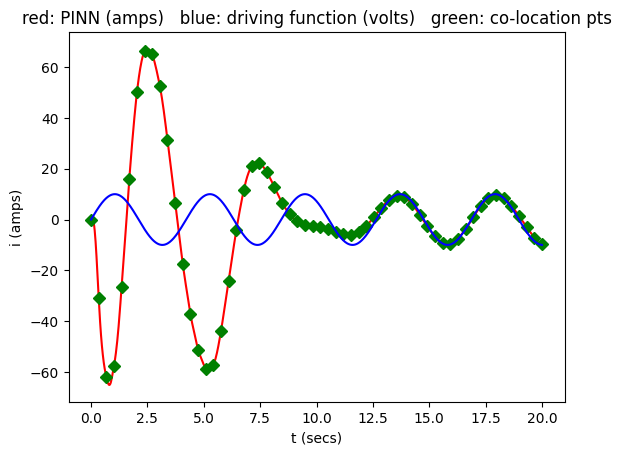

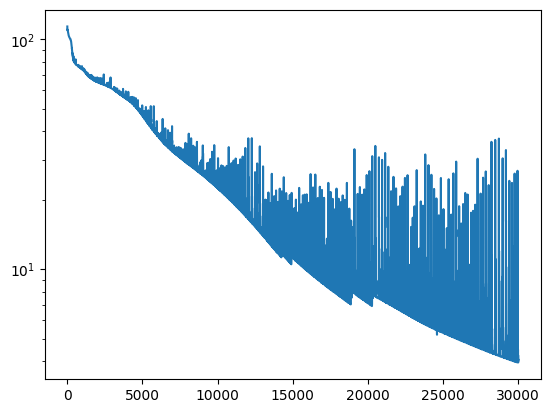

In [ ]:

import datetime
import os

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math

torch.manual_seed(42)
###########

# Hyperparameters
batch_size = 1
epochs = 30000
learning_rate = 0.001
t_dur = 20  # simulation duration, secs
ni = 3  # number coloc pts per sec

# Circuit Parameters

# Driving Force
Vpk = 10.0  # peak voltage, volts
V_0 = Vpk * math.sin(0.0)
w = 1.49 # radial frequency, radians/sec
# forcing function
def F(t):
  return Vpk * torch.sin(w * t)
# derivative of the forcing function
def dF(t):
  return w * Vpk * torch.cos(w * t)

# choose one set (under-, critically-, or over-damped)

# under-damped parameters set
R = 1.2  # resistance, ohm
L = 1.5  # inductance, H
C = 0.3  # capacitance, F
VC_0 = 12.0  # volts, initial capacitor voltage

# critically-damped parameters set
# R = 4.47  # resistance, ohm
# L = 1.5  # inductance, H
# C = 0.3  # capacitance, F
# VC_0 = 12.0  # volts, initial capacitor voltage

# over-damped parameter set
# R = 6.0  # resistance, ohm
# L = 1.5  # inductance, H
# C = 0.3  # capacitance, F
# VC_0 = 12.0  # volts, initial capacitor voltage

# co-location points
t_range = [0, int(t_dur)]
ncoloc = int(ni) * t_range[1]  # number of co-location pts
t_coloc = torch.FloatTensor(np.linspace(t_range[0], t_range[1],
                                        ncoloc, endpoint=True).reshape(-1, 1))
t_coloc.requires_grad = True  # dependant variable in a gradient

# initial conditions:
   #  f(t) initial conditions
t_init = torch.FloatTensor(np.array([0.0]).reshape(-1, 1))  # time, sec
i_init = torch.FloatTensor(np.array([0.0]).reshape(-1, 1))  # current, A

   #  f'(t) initial conditions
t_init2 = torch.FloatTensor(np.array([0.0]).reshape(-1, 1))  # time, sec
v_init2 = torch.FloatTensor(np.array([F(t_init2)]).reshape(-1,1))  # L * d/dt(i) = F(0)
t_init2.requires_grad = True  # dependant variable in a gradient

# Build neural network model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.model_layers = nn.Sequential(
            nn.Linear(1, 128),
            nn.GELU(),
            nn.Linear(128,128),
            nn.GELU(),
            nn.Linear(128,1),
        )
    def forward(self, x):
      for layer in self.model_layers:
            x = layer(x)
      return x

def squared_difference(input, target):
    return (input - target) ** 2

# instantiate model
model = NeuralNetwork()
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=learning_rate)

# closure function - PyTorch
#    computes loss, clears gradients, back pass to compute gradients
def closure(): # clears gradients, computes and returns loss

  # model_loss1: initial condition i_init @ t_init -> f(t) initial condition
        pred_init = model(t_init)
        model_loss1 = torch.mean(squared_difference(pred_init, i_init))

  # model_loss2: collocation points
        pred_y = model(t_coloc)
        dfdx = torch.autograd.grad(pred_y.sum(), t_coloc, create_graph=True)[0]
        dfdx2 = torch.autograd.grad(dfdx.sum(), t_coloc, create_graph=True)[0]
        residual = dfdx2 + dfdx * (R / L) + pred_y / (L * C)
        model_loss2 = torch.mean(squared_difference(residual, dF(t_coloc)))

  # model_loss3: initial condition i_init2 @ t_init2 -> f'(t) initial condition
        pred_init2 = model(t_init2)
        dfdx = torch.autograd.grad(pred_init2.sum(), t_init2, create_graph=True)[0]  # f'(t)
        vl = dfdx * L  # inductor voltage due to dfdx
        model_loss3 = torch.mean(squared_difference(vl, v_init2))

  # total loss
        model_loss = model_loss1 + model_loss2 + model_loss3

        optimizer.zero_grad()
        # sets any previous gradient values to zero before running backward(),
        # or else the new gradient will be added to the old one

        model_loss.backward(retain_graph=True)  # calculates gradients from loss
        return model_loss

# Training loop - PyTorch
loss_log = np.zeros(epochs)
for epoch in range(epochs):
  optimizer.step(closure)  #  updates model weights
  loss = closure().item()  # converts tensor value to numpy
  loss_log[epoch] = loss
#  if epoch % 100 == 0:
#    print(f'epoch = {epoch}  loss = {loss}')


# compare PINN results vs analytical results
num_test_pts = 1000
t_test = torch.FloatTensor(np.linspace(t_range[0], t_range[1], num_test_pts, endpoint=True)).reshape(-1, 1)
i_calc = np.zeros(num_test_pts)

i_train = model(t_coloc)  # for plotting co-location pts
i_test = model(t_test)  # iPINN results

F_test = np.zeros(num_test_pts)

# driving function test points
F_test = F(t_test)

# Analytical results
alpha = R / (2 * L)
for i in range(num_test_pts):
    # choose one matching the chosen circuit parameter set
    i_calc[i] = 5.57 * math.exp(-0.4 * t_test[i]) * np.sin(1.44 * t_test[i])  # under-damped
    # i_calc[i] = (VC_0 / L) * t_test[i] * math.exp(-1 * alpha * t_test[i])  # critically-damped
    # i_calc[i] = 3.0 * (math.exp(-0.67 * t_test[i]) - math.exp(-3.33 * t_test[i]))  # over-damped

with torch.no_grad():
  plt.plot(t_test.numpy(),i_test.numpy(), 'r', t_coloc.numpy(), i_train.numpy(),
           'Dg', t_test.numpy(), F_test, 'b')
plt.title('red: PINN (amps)   blue: driving function (volts)   green: co-location pts')
plt.xlabel('t (secs)')
plt.ylabel('i (amps)')
# plt.xlim(20,50)
# plt.ylim(-1, 1)
plt.show()
plt.plot(loss_log)
plt.yscale("log")
plt.show()

# Save result data to file
# pinn_data = np.stack((t_test, i_test), axis=1)
# np.save('[insert path here]/pinn_data.npy', pinn_data)